In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Ajustar las opciones de pandas para mostrar todo el DataFrame
pd.set_option('display.max_rows', None)  # No limitar el número de filas
pd.set_option('display.max_columns', None)  # No limitar el número de columnas
pd.set_option('display.width', None)  # No limitar el ancho de la salida
pd.set_option('display.max_colwidth', None)  # No limitar el ancho de las columnas

In [14]:
#Reguladores no se comparten
#Regulados si se comparten

sano_aux = pd.read_csv('../output-files/Auxin_regulatoryNetwork_healthy_fam.tsv', delimiter="\t", header=0,usecols=[0, 2])
enfermo_aux = pd.read_csv('../data/AuxinMip.tsv', delimiter="\t", header=None, usecols=[0, 2])

sano_bra = pd.read_csv('../output-files/Brassinos_regulatoryNetwork_healthy_fam.tsv', delimiter="\t", header=0,usecols=[0, 2])
enfermo_bra = pd.read_csv('../data/BrassinoMip.tsv', delimiter="\t", header=None, usecols=[0, 2])

sano_myc = pd.read_csv('../output-files/MYC2_regulatoryNetwork_healthy_fam.tsv', delimiter="\t", header=0,usecols=[0, 2])
enfermo_myc = pd.read_csv('../data/MYC2_net.tsv', delimiter="\t", header=None, usecols=[0, 2])


bhlh_tomato = pd.read_csv('../data/BHLHtomato.txt', delimiter="\t", header=0, names=['BHLH'])
bhlh_pennelli = pd.read_csv('../data/BHLHTomatoPennelli.txt',delimiter="\t", header=None, names=['BHLH'])





In [ ]:
bhlh = pd.concat([bhlh_tomato["BHLH"],bhlh_pennelli["BHLH"]], ignore_index=True).to_frame()
bhlh_tomato.head()
bhlh.head()
type(bhlh)
bhlh

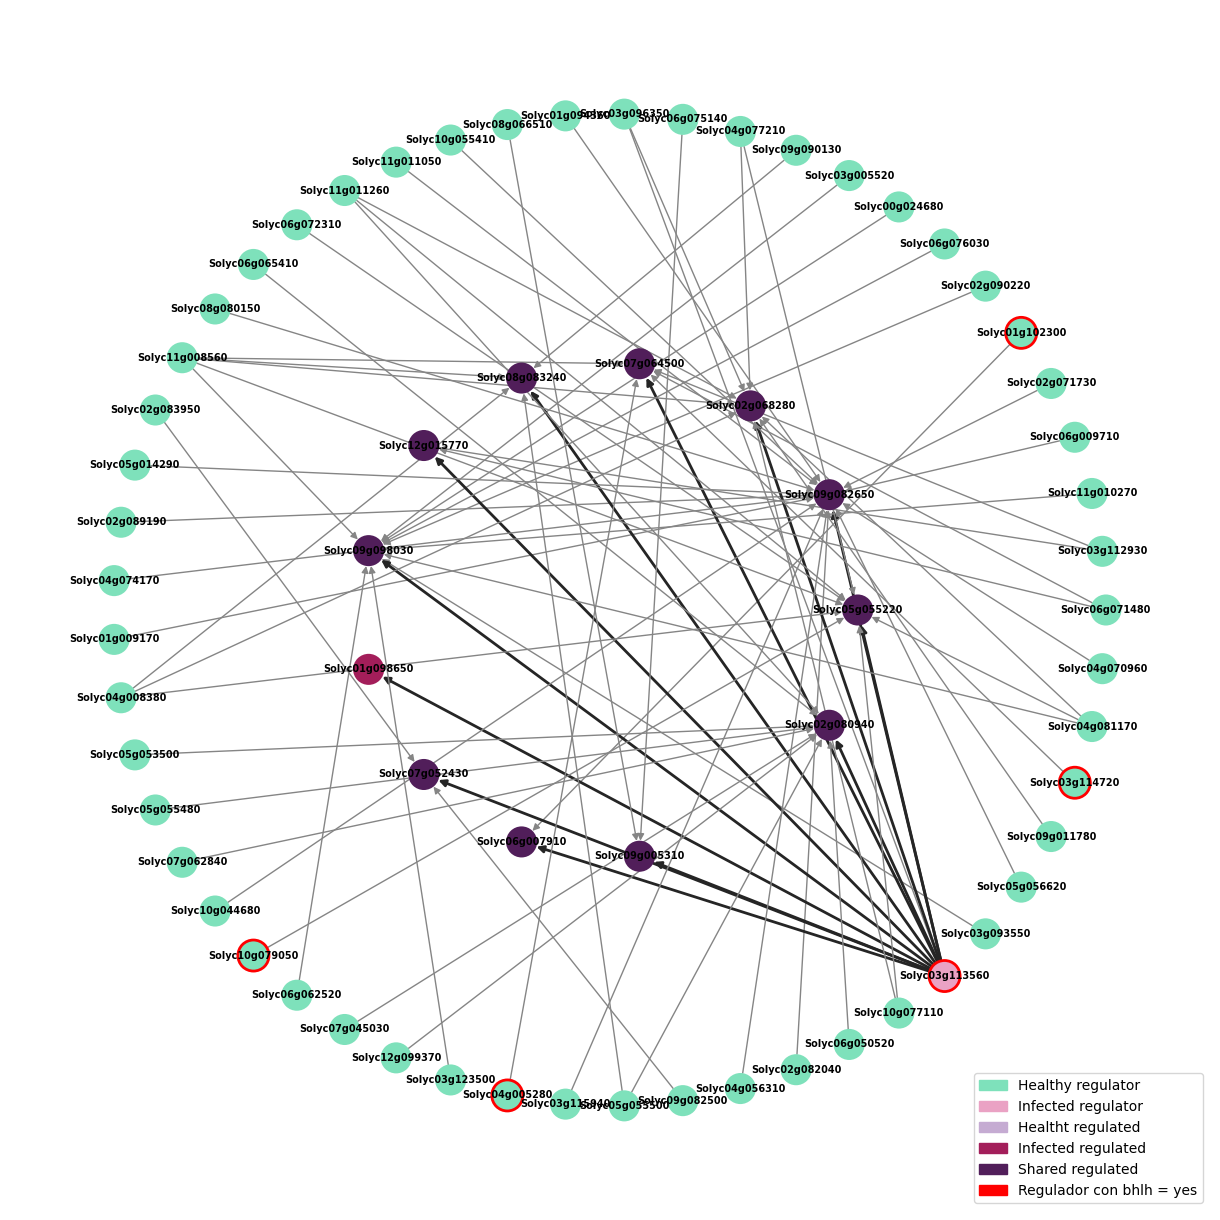

In [12]:
sano_aux['red'] = 'sano'
enfermo_aux['red'] = 'enfermo'
sano_aux

enfermo_aux.rename(columns={enfermo_aux.columns[0]: 'regulador'}, inplace=True)
enfermo_aux.rename(columns={enfermo_aux.columns[1]: 'regulon'}, inplace=True)
enfermo_aux

df_concatenado = pd.concat([sano_aux, enfermo_aux], ignore_index=True)
df=df_concatenado
df

# Reclasificar para columna 1 regulador
repetidos_regulador = set(enfermo_aux['regulador']).intersection(set(sano_aux['regulador']))
df['tipo_regulador'] = df['red']
df.loc[df['regulador'].isin(repetidos_regulador), 'tipo_regulador'] = 'ambos'


# Reclasificar para columna 1 regulon
repetidos_regulon = set(enfermo_aux['regulon']).intersection(set(sano_aux['regulon']))
df['tipo_regulon'] = df['red']
df.loc[df['regulon'].isin(repetidos_regulon), 'tipo_regulon'] = 'ambos'

df

###Grabar los FT en df

bhlh_list = set(bhlh['BHLH'])  # Convertir a conjunto para búsqueda eficiente

# Crear la nueva columna en df
df['bhlh'] = np.where(df['regulador'].isin(bhlh_list), 'yes', 'no')
df

### Identificar los reguladores con bhlh
reguladores_bhlh = set(df[df['bhlh'] == 'yes']['regulador'])
reguladores_bhlh


# Crear un grafo dirigido
df = df.drop_duplicates(subset=['regulador', 'regulon'])
G = nx.from_pandas_edgelist(df, source="regulador", target="regulon", create_using=nx.DiGraph())

# Identificar los nodos reguladores y regulados
reguladores = set(df['regulador'])  # Nodos reguladores
regulados = set(df['regulon'])      # Nodos regulados

# Asignar colores a los nodos

color_map = {
    'sano': '#7ee1bb',
    'enfermo': '#eaa2c4',
    'ambos': '#0a485f',
    'regulado_sano': '#c5abd2',
    'regulado_enfermo': '#a31e5a',
    'regulado_ambos': '#511e5a'
}

node_colors = []
for node in G.nodes():
    if node in reguladores:
        tipo_regulador = df[df['regulador'] == node]['tipo_regulador'].values[0]
        node_colors.append(color_map[tipo_regulador])
    elif node in regulados:
        tipo_regulon = df[df['regulon'] == node]['tipo_regulon'].values[0]
        node_colors.append(color_map[f'regulado_{tipo_regulon}'])

node_border_colors = []
for node in G.nodes():
    if node in reguladores_bhlh:
        node_border_colors.append('red')  # Borde rojo para reguladores con bhlh = 'yes'
    else:
        node_border_colors.append('none')  # Borde negro para otros nodos

# Posicionar los nodos
pos = {}


# Posicionar regulados en el centro (distribuidos aleatoriamente dentro de un círculo pequeño)
#num_regulados = len(regulados)
#if num_regulados > 0:
#    radius = 0.5  # Radio del círculo pequeño para los regulados
#    angles = np.linspace(0, 2 * np.pi, num_regulados, endpoint=False)  # Ángulos equiespaciados
#    for i, node in enumerate(regulados):
#        r = np.sqrt(np.random.uniform(0, radius**2))  # Radio aleatorio
#        pos[node] = (r * np.cos(angles[i]), r * np.sin(angles[i]))  # Coordenadas cartesianas


# Posicionar regulados en el centro (distribuidos en un círculo pequeño)
num_regulados = len(regulados)
if num_regulados > 0:
    radius = 0.5  # Radio del círculo pequeño para los regulados
    angles = np.linspace(0, 2 * np.pi, num_regulados, endpoint=False)  # Ángulos equiespaciados
    for i, node in enumerate(regulados):
        pos[node] = (radius * np.cos(angles[i]), radius * np.sin(angles[i]))  # Coordenadas cartesianas

# Posicionar reguladores en el perímetro (layout circular)
pos_reguladores = nx.circular_layout(reguladores)  # Layout circular para los reguladores
for node in reguladores:
    pos[node] = pos_reguladores[node]  # Asignar posiciones a los reguladores
regulados

# Asegurarse de que todos los nodos tengan posiciones
for node in G.nodes():
    if node not in pos:
        pos[node] = np.random.rand(2)  # Asignar una posición aleatoria si no tiene


# Asignar colores a las conexiones (edges) en función del valor de 'red'
# Asignar colores y grosores a las conexiones (edges) en función del valor de 'red'
edge_colors = []
edge_widths = []

for u, v in G.edges():
    # Filtrar el DataFrame para obtener la fila correspondiente
    row = df[(df['regulador'] == u) & (df['regulon'] == v)]
    
    if not row.empty:  # Si encontramos la fila en el DataFrame
        if row['red'].values[0] == 'sano':  # Condición para 'sano'
            edge_colors.append('#858585')
            edge_widths.append(1)  # Grosor para conexiones 'sano'
        else:  # Para 'enfermo' o cualquier otro valor
            edge_colors.append('#252525')
            edge_widths.append(2)  # Grosor para conexiones 'enfermo'


# Dibujar el grafo
plt.figure(figsize=(12, 12))  # Tamaño de la figura
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, 
        edge_color=edge_colors,  width=edge_widths, font_size=7, arrows=True, font_weight='bold', 
        edgecolors=node_border_colors, linewidths=2)



# Add legend for node colors
import matplotlib.patches as mpatches

# Define legend labels and colors
sano_patch = mpatches.Patch(color='#7ee1bb', label='Healthy regulator')
enfermo_patch = mpatches.Patch(color='#eaa2c4', label='Infected regulator')
enfermo_ambos_patch = mpatches.Patch(color='#0a485f', label='Shared regulator')
reg_sano_patch = mpatches.Patch(color='#c5abd2', label='Healtht regulated')
reg_enfermo_patch = mpatches.Patch(color='#a31e5a', label='Infected regulated')
reg_ambos_patch = mpatches.Patch(color='#511e5a', label='Shared regulated')

# Display legend
bhlh_patch = mpatches.Patch(color='red', label='Regulador con bhlh = yes')
plt.legend(handles=[sano_patch, enfermo_patch, reg_sano_patch, reg_enfermo_patch, reg_ambos_patch, bhlh_patch], loc='lower right')

# Mostrar y guardar la figura
plt.savefig('../output-images/aux-tomate-sano-enfermo-regulacion.png', dpi=300, bbox_inches='tight')  # Guardar la imagen
plt.show()


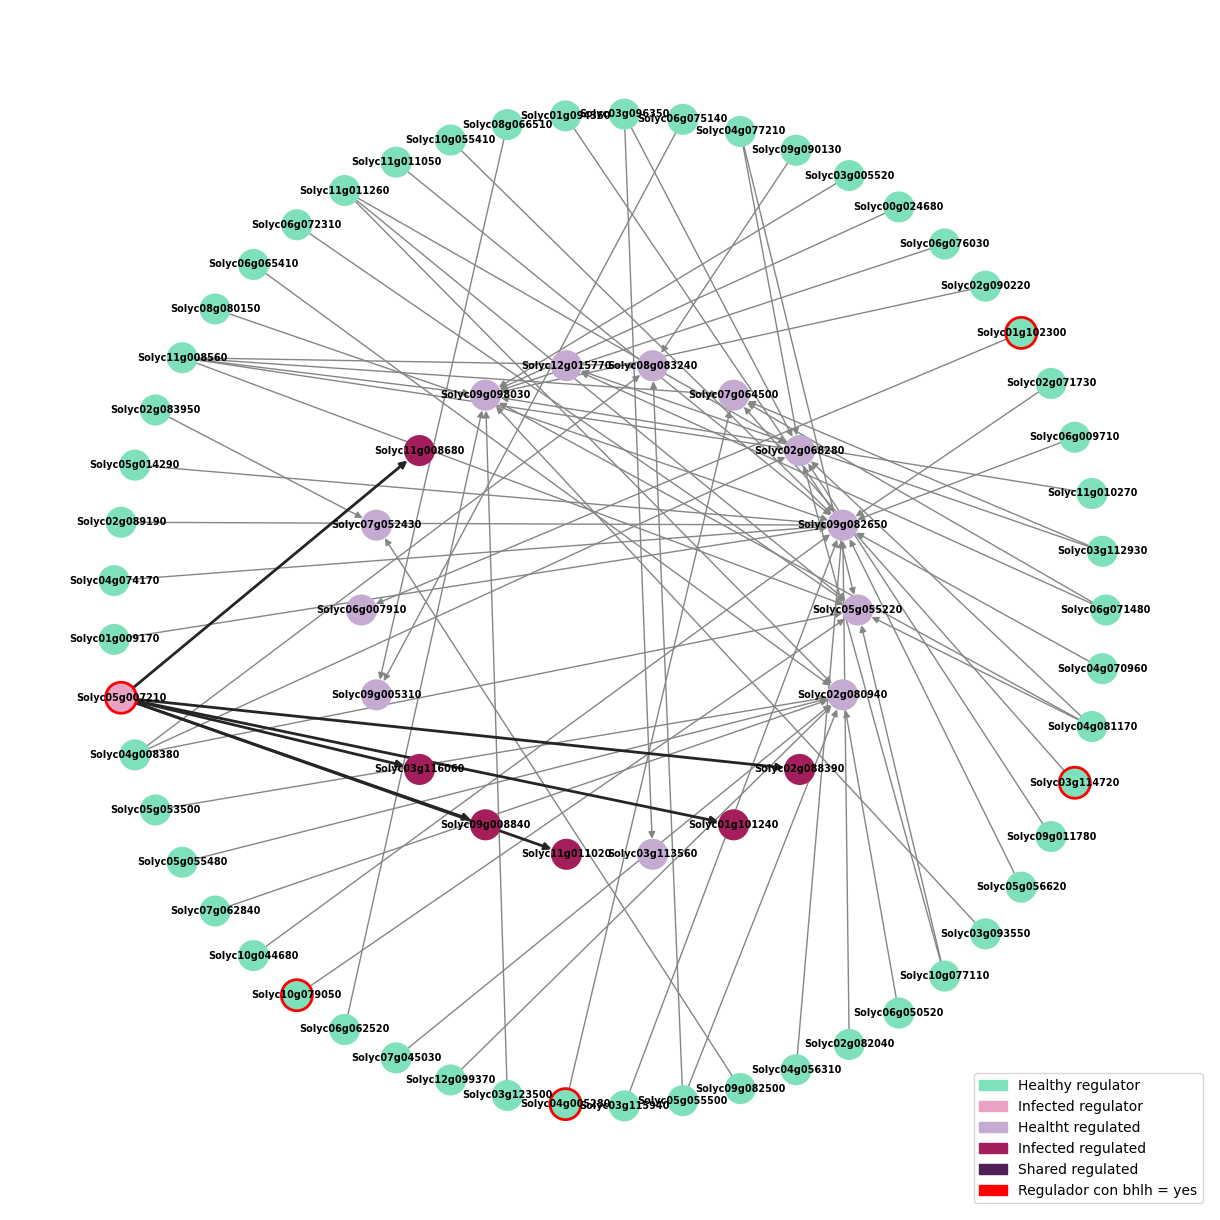

In [10]:
sano_bra['red'] = 'sano'
enfermo_bra['red'] = 'enfermo'
sano_bra

enfermo_bra.rename(columns={enfermo_bra.columns[0]: 'regulador'}, inplace=True)
enfermo_bra.rename(columns={enfermo_bra.columns[1]: 'regulon'}, inplace=True)
enfermo_bra

df_concatenado = pd.concat([sano_bra, enfermo_bra], ignore_index=True)
df=df_concatenado
df

# Reclasificar para columna 1 regulador
repetidos_regulador = set(enfermo_bra['regulador']).intersection(set(sano_bra['regulador']))
df['tipo_regulador'] = df['red']
df.loc[df['regulador'].isin(repetidos_regulador), 'tipo_regulador'] = 'ambos'


# Reclasificar para columna 1 regulon
repetidos_regulon = set(enfermo_bra['regulon']).intersection(set(sano_bra['regulon']))
df['tipo_regulon'] = df['red']
df.loc[df['regulon'].isin(repetidos_regulon), 'tipo_regulon'] = 'ambos'

df

###Grabar los FT en df

bhlh_list = set(bhlh['BHLH'])  # Convertir a conjunto para búsqueda eficiente

# Crear la nueva columna en df
df['bhlh'] = np.where(df['regulador'].isin(bhlh_list), 'yes', 'no')
df

### Identificar los reguladores con bhlh
reguladores_bhlh = set(df[df['bhlh'] == 'yes']['regulador'])
reguladores_bhlh


# Crear un grafo dirigido
df = df.drop_duplicates(subset=['regulador', 'regulon'])
G = nx.from_pandas_edgelist(df, source="regulador", target="regulon", create_using=nx.DiGraph())

# Identificar los nodos reguladores y regulados
reguladores = set(df['regulador'])  # Nodos reguladores
regulados = set(df['regulon'])      # Nodos regulados

# Asignar colores a los nodos

color_map = {
    'sano': '#7ee1bb',
    'enfermo': '#eaa2c4',
    'ambos': '#0a485f',
    'regulado_sano': '#c5abd2',
    'regulado_enfermo': '#a31e5a',
    'regulado_ambos': '#511e5a'
}

node_colors = []
for node in G.nodes():
    if node in reguladores:
        tipo_regulador = df[df['regulador'] == node]['tipo_regulador'].values[0]
        node_colors.append(color_map[tipo_regulador])
    elif node in regulados:
        tipo_regulon = df[df['regulon'] == node]['tipo_regulon'].values[0]
        node_colors.append(color_map[f'regulado_{tipo_regulon}'])

node_border_colors = []
for node in G.nodes():
    if node in reguladores_bhlh:
        node_border_colors.append('red')  # Borde rojo para reguladores con bhlh = 'yes'
    else:
        node_border_colors.append('none')  # Borde negro para otros nodos

# Posicionar los nodos
pos = {}


# Posicionar regulados en el centro (distribuidos aleatoriamente dentro de un círculo pequeño)
#num_regulados = len(regulados)
#if num_regulados > 0:
#    radius = 0.5  # Radio del círculo pequeño para los regulados
#    angles = np.linspace(0, 2 * np.pi, num_regulados, endpoint=False)  # Ángulos equiespaciados
#    for i, node in enumerate(regulados):
#        r = np.sqrt(np.random.uniform(0, radius**2))  # Radio aleatorio
#        pos[node] = (r * np.cos(angles[i]), r * np.sin(angles[i]))  # Coordenadas cartesianas


# Posicionar regulados en el centro (distribuidos en un círculo pequeño)
num_regulados = len(regulados)
if num_regulados > 0:
    radius = 0.5  # Radio del círculo pequeño para los regulados
    angles = np.linspace(0, 2 * np.pi, num_regulados, endpoint=False)  # Ángulos equiespaciados
    for i, node in enumerate(regulados):
        pos[node] = (radius * np.cos(angles[i]), radius * np.sin(angles[i]))  # Coordenadas cartesianas

# Posicionar reguladores en el perímetro (layout circular)
pos_reguladores = nx.circular_layout(reguladores)  # Layout circular para los reguladores
for node in reguladores:
    pos[node] = pos_reguladores[node]  # Asignar posiciones a los reguladores
regulados

# Asegurarse de que todos los nodos tengan posiciones
for node in G.nodes():
    if node not in pos:
        pos[node] = np.random.rand(2)  # Asignar una posición aleatoria si no tiene


# Asignar colores a las conexiones (edges) en función del valor de 'red'
# Asignar colores y grosores a las conexiones (edges) en función del valor de 'red'
edge_colors = []
edge_widths = []

for u, v in G.edges():
    # Filtrar el DataFrame para obtener la fila correspondiente
    row = df[(df['regulador'] == u) & (df['regulon'] == v)]
    
    if not row.empty:  # Si encontramos la fila en el DataFrame
        if row['red'].values[0] == 'sano':  # Condición para 'sano'
            edge_colors.append('#858585')
            edge_widths.append(1)  # Grosor para conexiones 'sano'
        else:  # Para 'enfermo' o cualquier otro valor
            edge_colors.append('#252525')
            edge_widths.append(2)  # Grosor para conexiones 'enfermo'


# Dibujar el grafo
plt.figure(figsize=(12, 12))  # Tamaño de la figura
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, 
        edge_color=edge_colors,  width=edge_widths, font_size=7, arrows=True, font_weight='bold', 
        edgecolors=node_border_colors, linewidths=2)



# Add legend for node colors
import matplotlib.patches as mpatches

# Define legend labels and colors
sano_patch = mpatches.Patch(color='#7ee1bb', label='Healthy regulator')
enfermo_patch = mpatches.Patch(color='#eaa2c4', label='Infected regulator')
enfermo_ambos_patch = mpatches.Patch(color='#0a485f', label='Shared regulator')
reg_sano_patch = mpatches.Patch(color='#c5abd2', label='Healtht regulated')
reg_enfermo_patch = mpatches.Patch(color='#a31e5a', label='Infected regulated')
reg_ambos_patch = mpatches.Patch(color='#511e5a', label='Shared regulated')

# Display legend
bhlh_patch = mpatches.Patch(color='red', label='Regulador con bhlh = yes')
plt.legend(handles=[sano_patch, enfermo_patch, reg_sano_patch, reg_enfermo_patch, reg_ambos_patch, bhlh_patch], loc='lower right')

# Mostrar y guardar la figura
plt.savefig('../output-images/bra-tomate-sano-enfermo-regulacion.png', dpi=300, bbox_inches='tight')  # Guardar la imagen
plt.show()


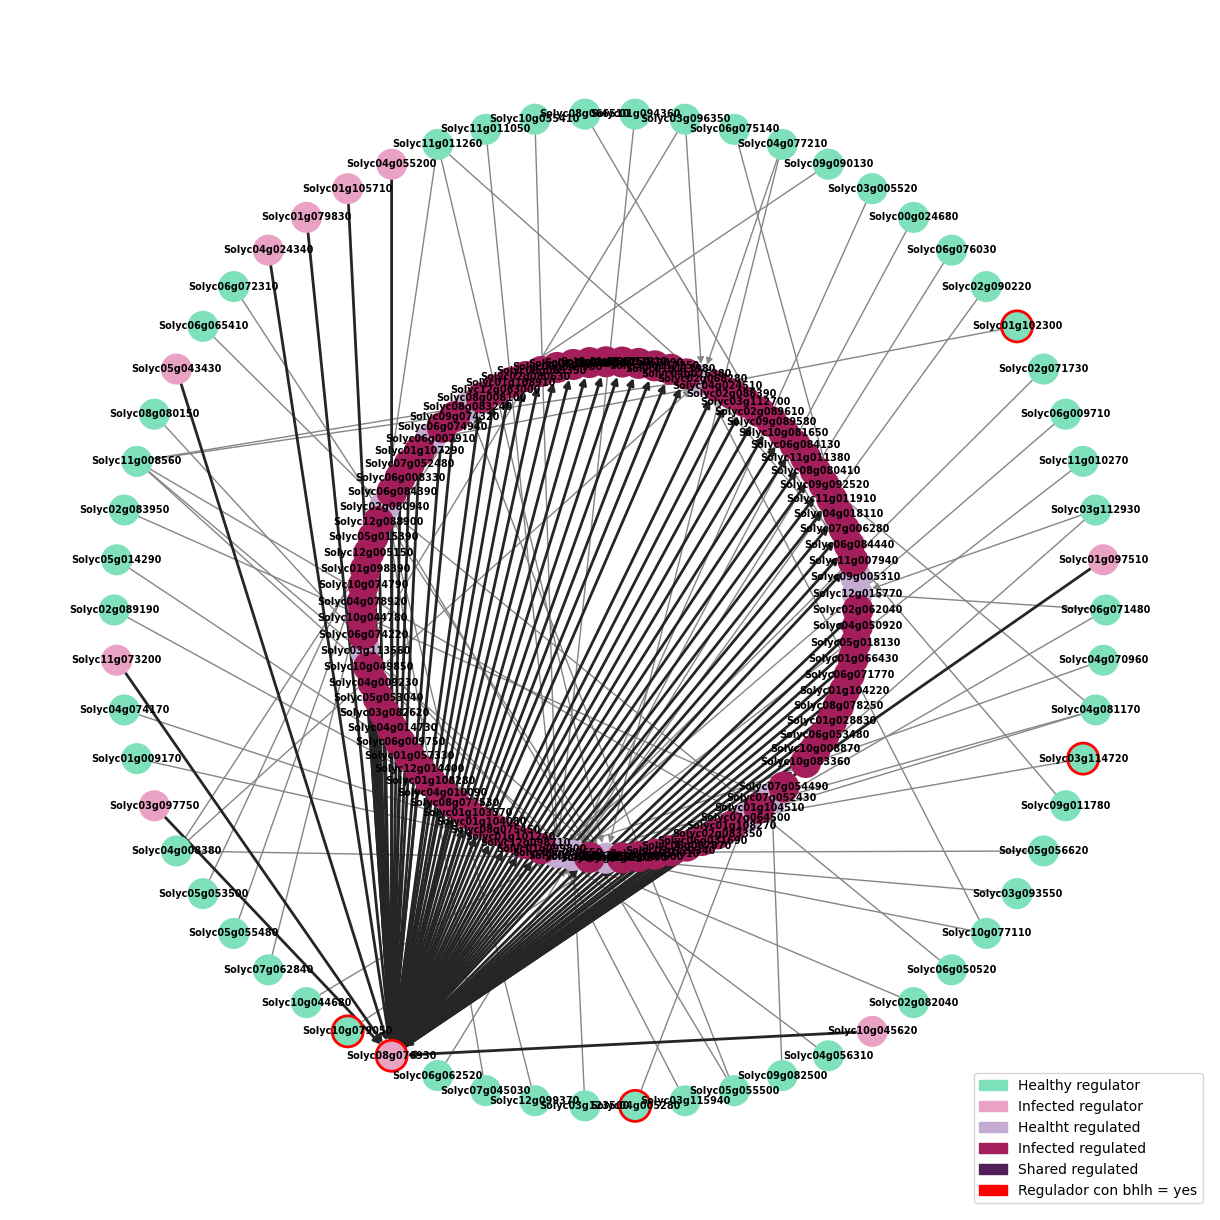

In [15]:
sano_myc['red'] = 'sano'
enfermo_myc['red'] = 'enfermo'
sano_myc

enfermo_myc.rename(columns={enfermo_myc.columns[0]: 'regulador'}, inplace=True)
enfermo_myc.rename(columns={enfermo_myc.columns[1]: 'regulon'}, inplace=True)
enfermo_myc

df_concatenado = pd.concat([sano_myc, enfermo_myc], ignore_index=True)
df=df_concatenado
df

# Reclasificar para columna 1 regulador
repetidos_regulador = set(enfermo_myc['regulador']).intersection(set(sano_myc['regulador']))
df['tipo_regulador'] = df['red']
df.loc[df['regulador'].isin(repetidos_regulador), 'tipo_regulador'] = 'ambos'


# Reclasificar para columna 1 regulon
repetidos_regulon = set(enfermo_myc['regulon']).intersection(set(sano_bra['regulon']))
df['tipo_regulon'] = df['red']
df.loc[df['regulon'].isin(repetidos_regulon), 'tipo_regulon'] = 'ambos'

df

###Grabar los FT en df

bhlh_list = set(bhlh['BHLH'])  # Convertir a conjunto para búsqueda eficiente

# Crear la nueva columna en df
df['bhlh'] = np.where(df['regulador'].isin(bhlh_list), 'yes', 'no')
df

### Identificar los reguladores con bhlh
reguladores_bhlh = set(df[df['bhlh'] == 'yes']['regulador'])
reguladores_bhlh


# Crear un grafo dirigido
df = df.drop_duplicates(subset=['regulador', 'regulon'])
G = nx.from_pandas_edgelist(df, source="regulador", target="regulon", create_using=nx.DiGraph())

# Identificar los nodos reguladores y regulados
reguladores = set(df['regulador'])  # Nodos reguladores
regulados = set(df['regulon'])      # Nodos regulados

# Asignar colores a los nodos

color_map = {
    'sano': '#7ee1bb',
    'enfermo': '#eaa2c4',
    'ambos': '#0a485f',
    'regulado_sano': '#c5abd2',
    'regulado_enfermo': '#a31e5a',
    'regulado_ambos': '#511e5a'
}

node_colors = []
for node in G.nodes():
    if node in reguladores:
        tipo_regulador = df[df['regulador'] == node]['tipo_regulador'].values[0]
        node_colors.append(color_map[tipo_regulador])
    elif node in regulados:
        tipo_regulon = df[df['regulon'] == node]['tipo_regulon'].values[0]
        node_colors.append(color_map[f'regulado_{tipo_regulon}'])

node_border_colors = []
for node in G.nodes():
    if node in reguladores_bhlh:
        node_border_colors.append('red')  # Borde rojo para reguladores con bhlh = 'yes'
    else:
        node_border_colors.append('none')  # Borde negro para otros nodos

# Posicionar los nodos
pos = {}


# Posicionar regulados en el centro (distribuidos aleatoriamente dentro de un círculo pequeño)
#num_regulados = len(regulados)
#if num_regulados > 0:
#    radius = 0.5  # Radio del círculo pequeño para los regulados
#    angles = np.linspace(0, 2 * np.pi, num_regulados, endpoint=False)  # Ángulos equiespaciados
#    for i, node in enumerate(regulados):
#        r = np.sqrt(np.random.uniform(0, radius**2))  # Radio aleatorio
#        pos[node] = (r * np.cos(angles[i]), r * np.sin(angles[i]))  # Coordenadas cartesianas


# Posicionar regulados en el centro (distribuidos en un círculo pequeño)
num_regulados = len(regulados)
if num_regulados > 0:
    radius = 0.5  # Radio del círculo pequeño para los regulados
    angles = np.linspace(0, 2 * np.pi, num_regulados, endpoint=False)  # Ángulos equiespaciados
    for i, node in enumerate(regulados):
        pos[node] = (radius * np.cos(angles[i]), radius * np.sin(angles[i]))  # Coordenadas cartesianas

# Posicionar reguladores en el perímetro (layout circular)
pos_reguladores = nx.circular_layout(reguladores)  # Layout circular para los reguladores
for node in reguladores:
    pos[node] = pos_reguladores[node]  # Asignar posiciones a los reguladores
regulados

# Asegurarse de que todos los nodos tengan posiciones
for node in G.nodes():
    if node not in pos:
        pos[node] = np.random.rand(2)  # Asignar una posición aleatoria si no tiene


# Asignar colores a las conexiones (edges) en función del valor de 'red'
# Asignar colores y grosores a las conexiones (edges) en función del valor de 'red'
edge_colors = []
edge_widths = []

for u, v in G.edges():
    # Filtrar el DataFrame para obtener la fila correspondiente
    row = df[(df['regulador'] == u) & (df['regulon'] == v)]
    
    if not row.empty:  # Si encontramos la fila en el DataFrame
        if row['red'].values[0] == 'sano':  # Condición para 'sano'
            edge_colors.append('#858585')
            edge_widths.append(1)  # Grosor para conexiones 'sano'
        else:  # Para 'enfermo' o cualquier otro valor
            edge_colors.append('#252525')
            edge_widths.append(2)  # Grosor para conexiones 'enfermo'


# Dibujar el grafo
plt.figure(figsize=(12, 12))  # Tamaño de la figura
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, 
        edge_color=edge_colors,  width=edge_widths, font_size=7, arrows=True, font_weight='bold', 
        edgecolors=node_border_colors, linewidths=2)



# Add legend for node colors
import matplotlib.patches as mpatches

# Define legend labels and colors
sano_patch = mpatches.Patch(color='#7ee1bb', label='Healthy regulator')
enfermo_patch = mpatches.Patch(color='#eaa2c4', label='Infected regulator')
enfermo_ambos_patch = mpatches.Patch(color='#0a485f', label='Shared regulator')
reg_sano_patch = mpatches.Patch(color='#c5abd2', label='Healtht regulated')
reg_enfermo_patch = mpatches.Patch(color='#a31e5a', label='Infected regulated')
reg_ambos_patch = mpatches.Patch(color='#511e5a', label='Shared regulated')

# Display legend
bhlh_patch = mpatches.Patch(color='red', label='Regulador con bhlh = yes')
plt.legend(handles=[sano_patch, enfermo_patch, reg_sano_patch, reg_enfermo_patch, reg_ambos_patch, bhlh_patch], loc='lower right')

# Mostrar y guardar la figura
plt.savefig('../output-images/myc-tomate-sano-enfermo-regulacion.png', dpi=300, bbox_inches='tight')  # Guardar la imagen
plt.show()
